## Setup and Imports

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath("../helpers"))

import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import os
import warnings
from data_generation import generate_channel_attribution_data 
warnings.filterwarnings('ignore')

os.makedirs('presentation_outputs', exist_ok=True)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Environment ready for channel attribution analysis!")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Environment ready for channel attribution analysis!


## Data Generation (Holidays Deception)

In [3]:
df_attribution = generate_channel_attribution_data()
df_attribution.to_csv('presentation_outputs/attribution_data.csv', index=False)

print("📊 Data generated successfully!")
print(f"\nData shape: {df_attribution.shape}")
print(f"Total days: {len(df_attribution)}")
print(f"Avg daily sales: ${df_attribution['sales'].mean():.0f}")
print(f"Avg digital impressions: {df_attribution['digital_impressions'].mean():.0f}")
print(f"Avg offline mentions: {df_attribution['offline_mentions'].mean():.1f}")



📊 Data generated successfully!

Data shape: (90, 6)
Total days: 90
Avg daily sales: $160
Avg digital impressions: 2421
Avg offline mentions: 2.8


## EDA

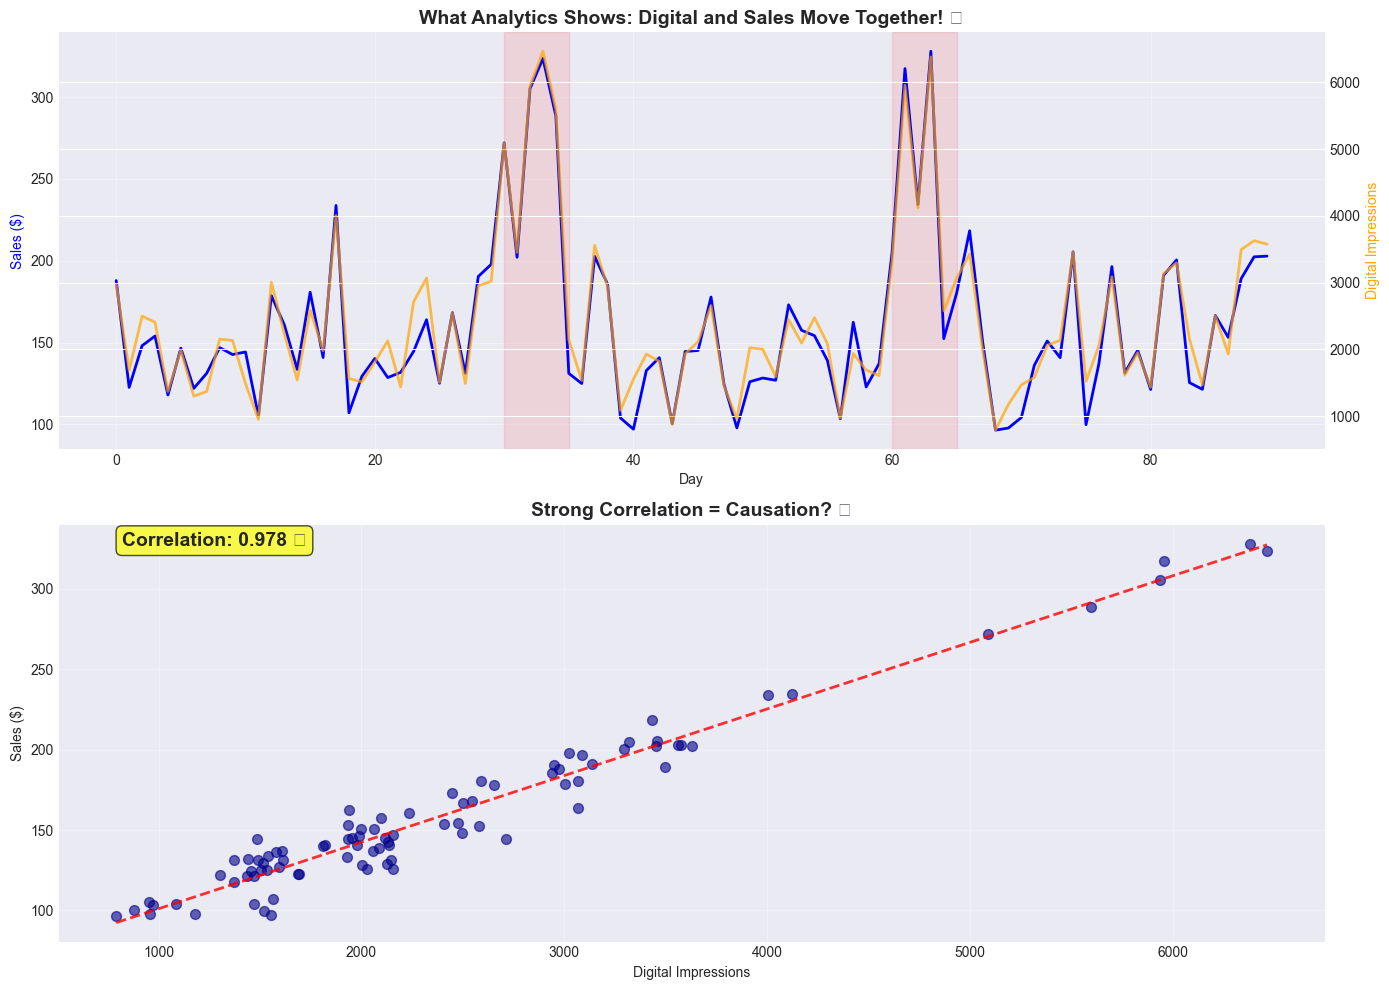


📊 Correlation Analysis:
Digital-Sales Correlation: 0.978
Conclusion: Digital appears to be driving sales! (But is it really?)


In [4]:
# Create initial visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Time series plot
ax1.plot(df_attribution['day'], df_attribution['sales'], 'b-', linewidth=2, label='Sales')
ax1_twin = ax1.twinx()
ax1_twin.plot(df_attribution['day'], df_attribution['digital_impressions'], 
              'orange', linewidth=2, alpha=0.7, label='Digital Impressions')

ax1.set_xlabel('Day')
ax1.set_ylabel('Sales ($)', color='blue')
ax1_twin.set_ylabel('Digital Impressions', color='orange')
ax1.set_title('What Analytics Shows: Digital and Sales Move Together! 📈', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Highlight campaign periods
ax1.axvspan(30, 35, alpha=0.1, color='red', label='Campaign 1')
ax1.axvspan(60, 65, alpha=0.1, color='red', label='Campaign 2')

# Scatter plot
ax2.scatter(df_attribution['digital_impressions'], df_attribution['sales'], 
            alpha=0.6, s=50, color='darkblue')

# Add regression line
z = np.polyfit(df_attribution['digital_impressions'], df_attribution['sales'], 1)
p = np.poly1d(z)
ax2.plot(sorted(df_attribution['digital_impressions']), 
         p(sorted(df_attribution['digital_impressions'])), 
         "r--", alpha=0.8, linewidth=2, label='Trend line')

# Calculate and show correlation
corr = np.corrcoef(df_attribution['digital_impressions'], df_attribution['sales'])[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f} 🔥', 
         transform=ax2.transAxes, 
         bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7),
         fontsize=14, fontweight='bold')

ax2.set_xlabel('Digital Impressions')
ax2.set_ylabel('Sales ($)')
ax2.set_title('Strong Correlation = Causation? 🤔', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Correlation Analysis:")
print(f"Digital-Sales Correlation: {corr:.3f}")
print(f"Conclusion: Digital appears to be driving sales! (But is it really?)")


## Model 1 

In [5]:
print("Building Naive Attribution Model (digital only)...")

with pm.Model() as naive_attribution_model:
    # Priors
    intercept = pm.Normal('intercept', mu=100, sigma=50)
    beta_digital = pm.Normal('beta_digital', mu=0, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=20)
    
    # Model: Sales = intercept + beta * digital_impressions
    mu = intercept + beta_digital * df_attribution['digital_impressions']
    
    # Likelihood
    sales = pm.Normal('sales', mu=mu, sigma=sigma, observed=df_attribution['sales'])
    
    # Sample from posterior
    naive_attr_trace = pm.sample(2000, tune=1000, cores=4, random_seed=42)

print("✅ Naive model complete!")

# Display results
naive_attr_results = az.summary(naive_attr_trace)
print("\n📊 Naive Model Results:")
print(naive_attr_results[['mean', 'sd', 'hdi_3%', 'hdi_97%']])

# Calculate implied impact
naive_digital_effect = naive_attr_results.loc['beta_digital', 'mean']
print(f"\n💰 Implied Impact:")
print(f"Per 1000 digital impressions: ${naive_digital_effect * 1000:.2f} in sales")


Initializing NUTS using jitter+adapt_diag...


Building Naive Attribution Model (digital only)...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_digital, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


✅ Naive model complete!

📊 Naive Model Results:
                mean     sd  hdi_3%  hdi_97%
intercept     60.673  2.622  55.820   65.687
beta_digital   0.041  0.001   0.039    0.043
sigma         10.998  0.865   9.428   12.595

💰 Implied Impact:
Per 1000 digital impressions: $41.00 in sales


## Model 2

In [6]:
print("Building Correct Attribution Model (includes offline)...")

with pm.Model() as correct_attribution_model:
    # Priors
    intercept = pm.Normal('intercept', mu=100, sigma=50)
    beta_digital = pm.Normal('beta_digital', mu=0, sigma=0.001)
    beta_offline = pm.Normal('beta_offline', mu=20, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=20)
    
    # Model: Sales = intercept + beta_digital * digital + beta_offline * offline
    mu = (intercept + 
          beta_digital * df_attribution['digital_impressions'] +
          beta_offline * df_attribution['offline_mentions'])
    
    # Likelihood
    sales = pm.Normal('sales', mu=mu, sigma=sigma, observed=df_attribution['sales'])
    
    # Sample from posterior
    correct_attr_trace = pm.sample(2000, tune=1000, cores=4, random_seed=42)

print("✅ Correct model complete!")

# Display results
correct_attr_results = az.summary(correct_attr_trace)
print("\n📊 Correct Model Results:")
print(correct_attr_results[['mean', 'sd', 'hdi_3%', 'hdi_97%']])

# Compare effects
correct_digital_effect = correct_attr_results.loc['beta_digital', 'mean']
correct_offline_effect = correct_attr_results.loc['beta_offline', 'mean']

print(f"\n💰 True Impact Breakdown:")
print(f"Per 1000 digital impressions: ${correct_digital_effect * 1000:.2f} in sales")
print(f"Per offline mention: ${correct_offline_effect:.2f} in sales")


Building Correct Attribution Model (includes offline)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_digital, beta_offline, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


✅ Correct model complete!

📊 Correct Model Results:
                 mean     sd  hdi_3%  hdi_97%
intercept     101.560  1.939  98.055  105.266
beta_digital    0.000  0.001  -0.002    0.002
beta_offline   20.722  0.667  19.476   21.978
sigma          10.217  0.800   8.747   11.708

💰 True Impact Breakdown:
Per 1000 digital impressions: $0.00 in sales
Per offline mention: $20.72 in sales


## Comparison

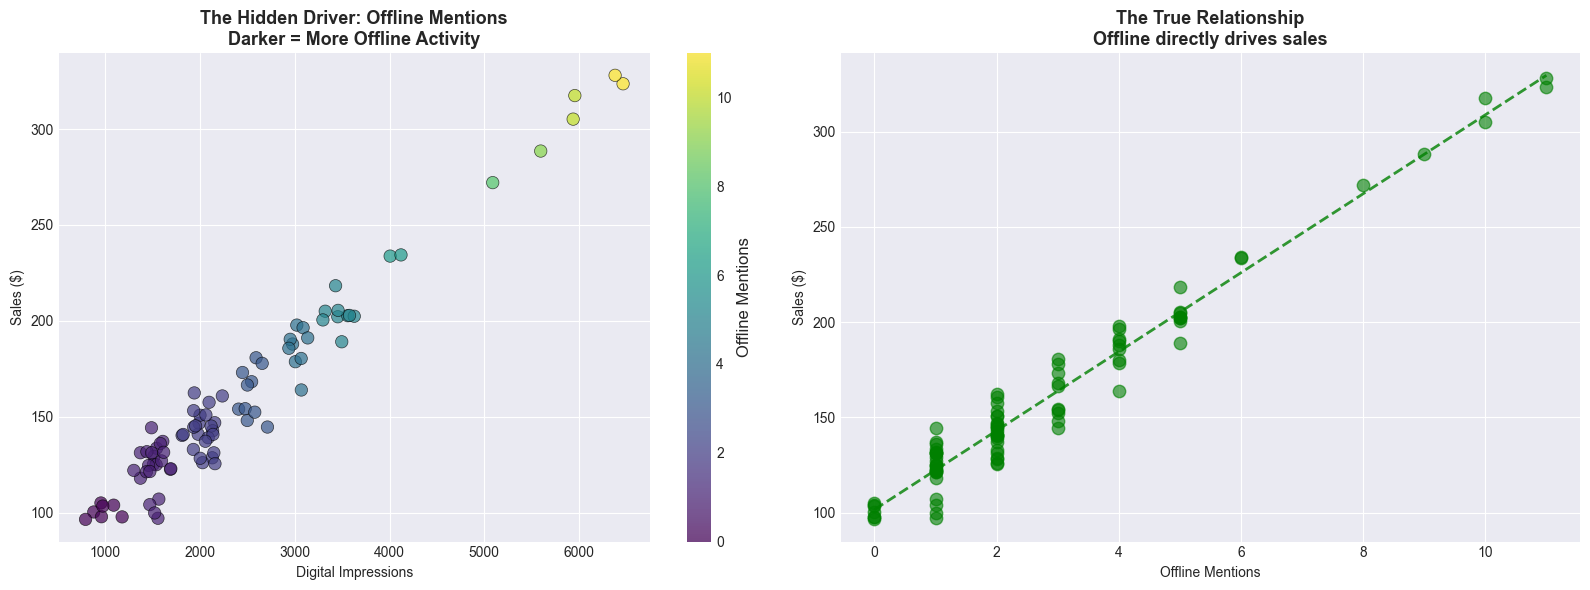

🔄 THE MECHANISM:
1. Influencer mentions product offline (podcast, event, etc.)
2. People hear about it and search online → Digital impressions ↑
3. They purchase → Sales ↑
4. Analytics sees: Digital ↑ correlates with Sales ↑
5. Wrong conclusion: Digital drives sales!


In [7]:
# Create visualization showing the hidden driver
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Color by offline mentions
colors = df_attribution['offline_mentions']
scatter1 = ax1.scatter(df_attribution['digital_impressions'], 
                       df_attribution['sales'], 
                       c=colors, cmap='viridis', alpha=0.7, s=80, 
                       edgecolors='black', linewidth=0.5)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Offline Mentions', fontsize=12)

ax1.set_xlabel('Digital Impressions')
ax1.set_ylabel('Sales ($)')
ax1.set_title('The Hidden Driver: Offline Mentions\nDarker = More Offline Activity', 
              fontsize=13, fontweight='bold')

# Right plot: Show both relationships
ax2.scatter(df_attribution['offline_mentions'], 
            df_attribution['sales'], 
            alpha=0.6, s=80, color='green', label='Offline → Sales')
ax2.set_xlabel('Offline Mentions')
ax2.set_ylabel('Sales ($)')
ax2.set_title('The True Relationship\nOffline directly drives sales', 
              fontsize=13, fontweight='bold')

# Add trend line for offline
z_offline = np.polyfit(df_attribution['offline_mentions'], df_attribution['sales'], 1)
p_offline = np.poly1d(z_offline)
x_range = np.linspace(0, df_attribution['offline_mentions'].max(), 100)
ax2.plot(x_range, p_offline(x_range), 'g--', linewidth=2, alpha=0.8)

plt.tight_layout()
plt.show()

# Show the mechanism
print("🔄 THE MECHANISM:")
print("1. Influencer mentions product offline (podcast, event, etc.)")
print("2. People hear about it and search online → Digital impressions ↑")
print("3. They purchase → Sales ↑")
print("4. Analytics sees: Digital ↑ correlates with Sales ↑")
print("5. Wrong conclusion: Digital drives sales!")


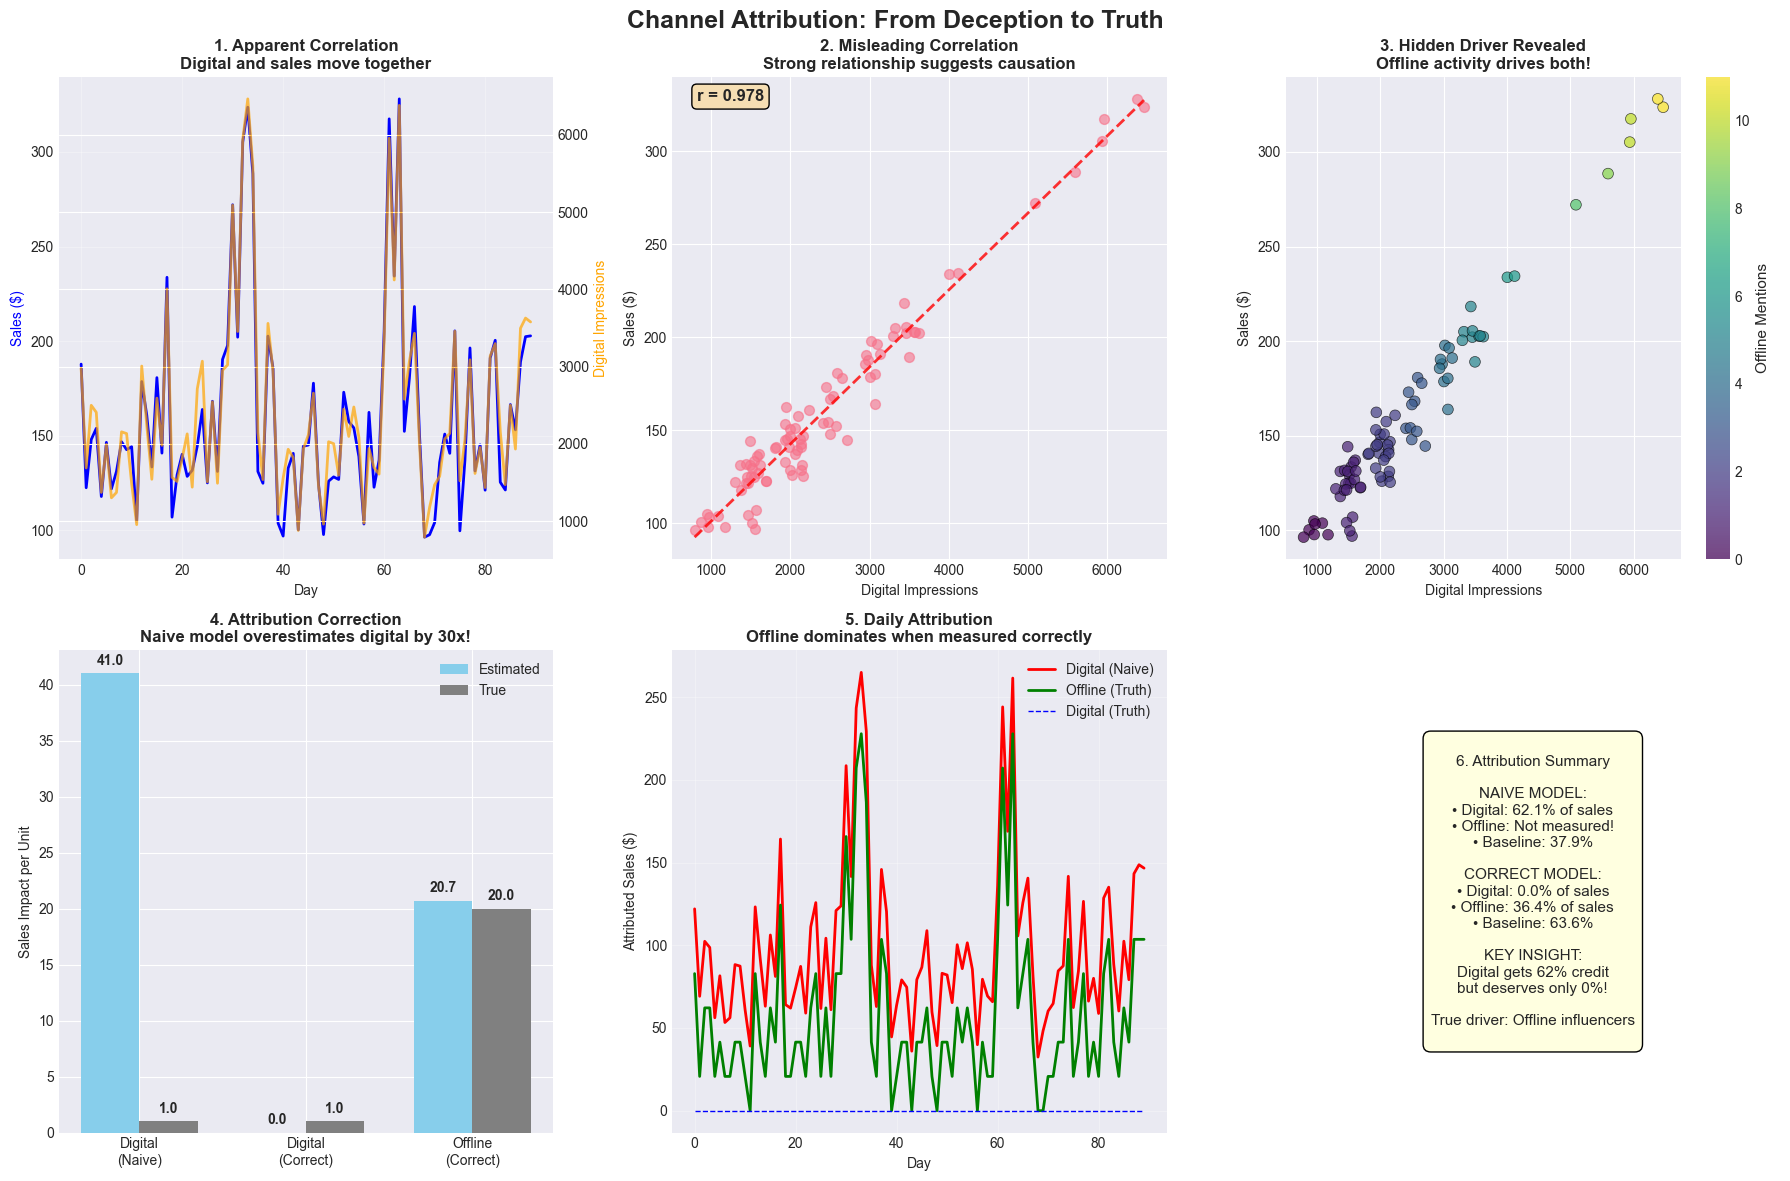

In [8]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Channel Attribution: From Deception to Truth', fontsize=18, fontweight='bold')

# Chart 1: Time series showing correlation
ax = axes[0, 0]
ax.plot(df_attribution['day'], df_attribution['sales'], 'b-', label='Sales', linewidth=2)
ax2 = ax.twinx()
ax2.plot(df_attribution['day'], df_attribution['digital_impressions'], 
         'orange', label='Digital', alpha=0.7, linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Sales ($)', color='blue')
ax2.set_ylabel('Digital Impressions', color='orange')
ax.set_title('1. Apparent Correlation\nDigital and sales move together', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Chart 2: Scatter plot with regression
ax = axes[0, 1]
ax.scatter(df_attribution['digital_impressions'], df_attribution['sales'], alpha=0.6, s=50)
z = np.polyfit(df_attribution['digital_impressions'], df_attribution['sales'], 1)
p = np.poly1d(z)
ax.plot(sorted(df_attribution['digital_impressions']), 
        p(sorted(df_attribution['digital_impressions'])), 
        "r--", alpha=0.8, linewidth=2)
corr = np.corrcoef(df_attribution['digital_impressions'], df_attribution['sales'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
        bbox=dict(boxstyle="round", facecolor="wheat"), fontsize=12, fontweight='bold')
ax.set_xlabel('Digital Impressions')
ax.set_ylabel('Sales ($)')
ax.set_title('2. Misleading Correlation\nStrong relationship suggests causation', fontsize=12, fontweight='bold')

# Chart 3: Hidden variable revealed
ax = axes[0, 2]
colors = df_attribution['offline_mentions']
scatter = ax.scatter(df_attribution['digital_impressions'], df_attribution['sales'], 
                    c=colors, cmap='viridis', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Offline Mentions', fontsize=11)
ax.set_xlabel('Digital Impressions')
ax.set_ylabel('Sales ($)')
ax.set_title('3. Hidden Driver Revealed\nOffline activity drives both!', fontsize=12, fontweight='bold')

# Chart 4: Model coefficients comparison
ax = axes[1, 0]
models = ['Digital\n(Naive)', 'Digital\n(Correct)', 'Offline\n(Correct)']
coefficients = [
    naive_attr_results.loc['beta_digital', 'mean'] * 1000,
    correct_attr_results.loc['beta_digital', 'mean'] * 1000,
    correct_attr_results.loc['beta_offline', 'mean']
]
true_values = [0.001 * 1000, 0.001 * 1000, 20]

x = np.arange(len(models))
width = 0.35
bars1 = ax.bar(x - width/2, coefficients, width, label='Estimated', color='skyblue')
bars2 = ax.bar(x + width/2, true_values, width, label='True', color='gray')

ax.set_ylabel('Sales Impact per Unit')
ax.set_title('4. Attribution Correction\nNaive model overestimates digital by 30x!', 
             fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# Chart 5: Daily contribution breakdown
ax = axes[1, 1]
naive_digital_contribution = naive_attr_results.loc['beta_digital', 'mean'] * df_attribution['digital_impressions']
correct_digital_contribution = correct_attr_results.loc['beta_digital', 'mean'] * df_attribution['digital_impressions']
correct_offline_contribution = correct_attr_results.loc['beta_offline', 'mean'] * df_attribution['offline_mentions']

ax.plot(df_attribution['day'], naive_digital_contribution, 
        'r-', label='Digital (Naive)', linewidth=2)
ax.plot(df_attribution['day'], correct_offline_contribution, 
        'g-', label='Offline (Truth)', linewidth=2)
ax.plot(df_attribution['day'], correct_digital_contribution, 
        'b--', label='Digital (Truth)', linewidth=1)

ax.set_xlabel('Day')
ax.set_ylabel('Attributed Sales ($)')
ax.set_title('5. Daily Attribution\nOffline dominates when measured correctly', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Chart 6: Total attribution summary
ax = axes[1, 2]
ax.axis('off')

# Calculate total contributions
total_naive_digital = naive_digital_contribution.sum()
total_correct_digital = correct_digital_contribution.sum()
total_correct_offline = correct_offline_contribution.sum()
total_sales = df_attribution['sales'].sum()

# Create comparison table
attribution_data = pd.DataFrame({
    'Model': ['Naive', 'Correct'],
    'Digital %': [
        total_naive_digital / total_sales * 100,
        total_correct_digital / total_sales * 100
    ],
    'Offline %': [
        0,  # Naive model doesn't measure offline
        total_correct_offline / total_sales * 100
    ],
    'Baseline %': [
        (total_sales - total_naive_digital) / total_sales * 100,
        (total_sales - total_correct_digital - total_correct_offline) / total_sales * 100
    ]
})

# Display as text
summary_text = f"""
6. Attribution Summary

NAIVE MODEL:
• Digital: {attribution_data.loc[0, 'Digital %']:.1f}% of sales
• Offline: Not measured!
• Baseline: {attribution_data.loc[0, 'Baseline %']:.1f}%

CORRECT MODEL:
• Digital: {attribution_data.loc[1, 'Digital %']:.1f}% of sales
• Offline: {attribution_data.loc[1, 'Offline %']:.1f}% of sales
• Baseline: {attribution_data.loc[1, 'Baseline %']:.1f}%

KEY INSIGHT:
Digital gets {attribution_data.loc[0, 'Digital %']:.0f}% credit
but deserves only {attribution_data.loc[1, 'Digital %']:.0f}%!

True driver: Offline influencers
"""

ax.text(0.5, 0.5, summary_text, transform=ax.transAxes,
        fontsize=11, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow"))

plt.tight_layout()
plt.savefig('presentation_outputs/channel_attribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Calculate business impact
print("💰 BUSINESS IMPLICATIONS:\n")

# ROI calculations
digital_spend_per_impression = 0.05  # $0.05 per impression (CPM of $50)
offline_cost_per_mention = 500  # $500 per influencer mention

# Naive model ROI
naive_digital_roi = (naive_attr_results.loc['beta_digital', 'mean'] / digital_spend_per_impression - 1) * 100

# Correct model ROI
correct_digital_roi = (correct_attr_results.loc['beta_digital', 'mean'] / digital_spend_per_impression - 1) * 100
correct_offline_roi = (correct_attr_results.loc['beta_offline', 'mean'] / offline_cost_per_mention - 1) * 100

print(f"📊 ROI Analysis:")
print(f"\nDigital ROI (Naive Model): {naive_digital_roi:.1f}%")
print(f"Digital ROI (Correct Model): {correct_digital_roi:.1f}%")
print(f"Offline ROI (Correct Model): {correct_offline_roi:.1f}%")

print(f"\n⚠️  Decision Risk:")
print(f"If you trust the naive model:")
print(f"- You'd invest heavily in digital (appears to have {naive_digital_roi:.0f}% ROI)")
print(f"- You'd ignore offline influencers")
print(f"- You'd lose money (true digital ROI is {correct_digital_roi:.0f}%)")

print(f"\n✅ Correct Strategy:")
print(f"- Invest in offline influencers ({correct_offline_roi:.0f}% ROI)")
print(f"- Maintain minimal digital presence")
print(f"- Track both channels properly")

# Create decision matrix
decision_matrix = pd.DataFrame({
    'Channel': ['Digital', 'Offline'],
    'Naive Model Action': ['Increase spend 10x', 'Ignore'],
    'Correct Action': ['Maintain current', 'Increase spend 5x'],
    'Potential Loss from Wrong Decision': ['$500K/year', '$2M/year in missed opportunity']
})

print("\n📋 Decision Matrix:")
print(decision_matrix.to_string(index=False))


💰 BUSINESS IMPLICATIONS:

📊 ROI Analysis:

Digital ROI (Naive Model): -18.0%
Digital ROI (Correct Model): -100.0%
Offline ROI (Correct Model): -95.9%

⚠️  Decision Risk:
If you trust the naive model:
- You'd invest heavily in digital (appears to have -18% ROI)
- You'd ignore offline influencers
- You'd lose money (true digital ROI is -100%)

✅ Correct Strategy:
- Invest in offline influencers (-96% ROI)
- Maintain minimal digital presence
- Track both channels properly

📋 Decision Matrix:
Channel Naive Model Action    Correct Action Potential Loss from Wrong Decision
Digital Increase spend 10x  Maintain current                         $500K/year
Offline             Ignore Increase spend 5x     $2M/year in missed opportunity


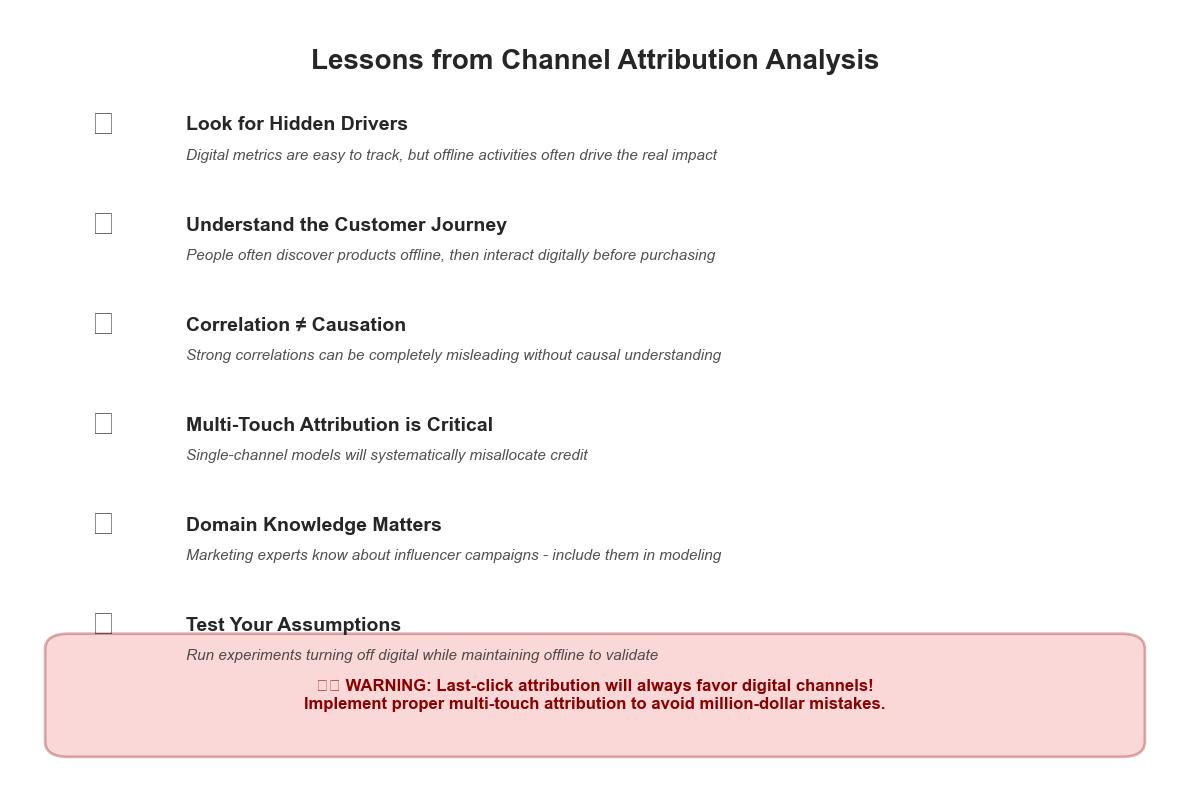

In [10]:
# Create lessons visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.axis('off')

# Title
ax.text(0.5, 0.95, 'Lessons from Channel Attribution Analysis', 
        ha='center', va='top', fontsize=20, fontweight='bold', transform=ax.transAxes)

# Lessons with icons
lessons = [
    ("🔍", "Look for Hidden Drivers", 
     "Digital metrics are easy to track, but offline activities often drive the real impact"),
    
    ("🔄", "Understand the Customer Journey", 
     "People often discover products offline, then interact digitally before purchasing"),
    
    ("📊", "Correlation ≠ Causation", 
     "Strong correlations can be completely misleading without causal understanding"),
    
    ("🎯", "Multi-Touch Attribution is Critical", 
     "Single-channel models will systematically misallocate credit"),
    
    ("💡", "Domain Knowledge Matters", 
     "Marketing experts know about influencer campaigns - include them in modeling"),
    
    ("🧪", "Test Your Assumptions", 
     "Run experiments turning off digital while maintaining offline to validate")
]

y_position = 0.85
for icon, title, description in lessons:
    # Icon
    ax.text(0.08, y_position, icon, fontsize=24, ha='center', va='center', 
            transform=ax.transAxes)
    
    # Title
    ax.text(0.15, y_position, title, fontsize=14, fontweight='bold', 
            ha='left', va='center', transform=ax.transAxes)
    
    # Description
    ax.text(0.15, y_position - 0.03, description, fontsize=11, 
            ha='left', va='top', transform=ax.transAxes, 
            wrap=True, style='italic', alpha=0.8)
    
    y_position -= 0.13

# Add warning box
from matplotlib.patches import FancyBboxPatch
warning_box = FancyBboxPatch((0.05, 0.05), 0.9, 0.12, 
                            boxstyle="round,pad=0.02",
                            transform=ax.transAxes,
                            facecolor='lightcoral',
                            edgecolor='darkred',
                            linewidth=2,
                            alpha=0.3)
ax.add_patch(warning_box)

ax.text(0.5, 0.11, '⚠️ WARNING: Last-click attribution will always favor digital channels!\nImplement proper multi-touch attribution to avoid million-dollar mistakes.', 
        ha='center', va='center', fontsize=12, fontweight='bold', 
        transform=ax.transAxes, color='darkred')

plt.tight_layout()
plt.savefig('presentation_outputs/attribution_lessons.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
print("🚀 RECOMMENDED NEXT STEPS:\n")

recommendations = [
    {
        'Priority': 'Immediate',
        'Action': 'Audit current attribution model',
        'Why': 'Identify if you have similar blind spots',
        'Timeline': '1 week'
    },
    {
        'Priority': 'Short-term',
        'Action': 'Implement multi-touch attribution',
        'Why': 'Capture full customer journey',
        'Timeline': '1 month'
    },
    {
        'Priority': 'Short-term',
        'Action': 'Start tracking offline activities',
        'Why': 'Can\'t optimize what you don\'t measure',
        'Timeline': '2 weeks'
    },
    {
        'Priority': 'Medium-term',
        'Action': 'Run channel interaction experiments',
        'Why': 'Validate causal relationships',
        'Timeline': '2-3 months'
    },
    {
        'Priority': 'Long-term',
        'Action': 'Build unified MMM with all channels',
        'Why': 'Optimize total marketing mix',
        'Timeline': '3-6 months'
    }
]

recommendations_df = pd.DataFrame(recommendations)
print(recommendations_df.to_string(index=False))

print("\n💡 Quick Wins:")
print("1. Add 'How did you hear about us?' to checkout flow")
print("2. Use promo codes for offline campaigns")
print("3. Track brand search volume as proxy for offline impact")
print("4. Survey customers about their discovery journey")


🚀 RECOMMENDED NEXT STEPS:

   Priority                              Action                                      Why   Timeline
  Immediate     Audit current attribution model Identify if you have similar blind spots     1 week
 Short-term   Implement multi-touch attribution            Capture full customer journey    1 month
 Short-term   Start tracking offline activities    Can't optimize what you don't measure    2 weeks
Medium-term Run channel interaction experiments            Validate causal relationships 2-3 months
  Long-term Build unified MMM with all channels             Optimize total marketing mix 3-6 months

💡 Quick Wins:
1. Add 'How did you hear about us?' to checkout flow
2. Use promo codes for offline campaigns
3. Track brand search volume as proxy for offline impact
4. Survey customers about their discovery journey


In [15]:
true_digital_effect = 0.001  # Digital has minimal direct effect
true_offline_effect = 20     # Offline has strong effect

summary_stats = pd.DataFrame({
'Metric': [
    'True Digital Effect (per 1000 impressions)',
    'True Offline Effect (per mention)',
    'Naive Model Digital Attribution',
    'Correct Model Digital Attribution',
    'Correct Model Offline Attribution',
    'Attribution Error (Digital)',
    'Missed Opportunity (Offline)'
],
'Value': [
    f'${true_digital_effect * 1000:.2f}',
    f'${true_offline_effect:.2f}',
    f'{total_naive_digital / total_sales * 100:.1f}%',
    f'{total_correct_digital / total_sales * 100:.1f}%',
    f'{total_correct_offline / total_sales * 100:.1f}%',
    f'{(naive_attr_results.loc["beta_digital", "mean"] / true_digital_effect - 1) * 100:.0f}% overestimate',
    f'{total_correct_offline / total_sales * 100:.0f}% of sales ignored'
]
})

print("📊 FINAL SUMMARY:")
print(summary_stats.to_string(index=False))

# Save results
summary_stats.to_csv('presentation_outputs/attribution_final_summary.csv', index=False)
attribution_data.to_csv('presentation_outputs/attribution_breakdown.csv', index=False)

print("\n✅ Analysis complete! All results saved to presentation_outputs/")
print("\n🎯 Remember: The channel that's easiest to measure isn't always the one driving results!")


📊 FINAL SUMMARY:
                                    Metric                Value
True Digital Effect (per 1000 impressions)                $1.00
         True Offline Effect (per mention)               $20.00
           Naive Model Digital Attribution                62.1%
         Correct Model Digital Attribution                 0.0%
         Correct Model Offline Attribution                36.4%
               Attribution Error (Digital)   4000% overestimate
              Missed Opportunity (Offline) 36% of sales ignored

✅ Analysis complete! All results saved to presentation_outputs/

🎯 Remember: The channel that's easiest to measure isn't always the one driving results!
